# Clustering
## Transformation

Transforming features that are heavily skewed can help clustering algorithms (like k-means) treat them more fairly. So we'll do that first.

**Speechiness and Instrumentalness**: These features are heavily skewed towards low values. Since clustering algorithms like k-means assume roughly spherical clusters (normally distributed features), applying a logarithmic or square root transformation can help normalize the distribution.

**Liveness** is also skewed towards lower values, so we'll do a log transformation here to spread out the lower values more evenly.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns
import numpy as np


df = pd.read_csv('processed_data.csv')
df = df.drop(columns='loudness') ## drop loudness because it is highly correlated with energy

df['speechiness_log'] = np.log1p(df['speechiness'])  # log(1 + x) to handle zeros
df['instrumentalness_log'] = np.log1p(df['instrumentalness'])
df['liveness_log'] = np.log1p(df['liveness'])


clustering_features = ['danceability', 'energy', 'valence', 'tempo', 
                       'acousticness', 'speechiness_log', 'instrumentalness_log', 'liveness_log']

X = df[clustering_features]

## Number of clusters

Before applying k-means, it’s important to decide on the number of clusters (k). We'll use the Elbow Method to help determine an appropriate value of k.

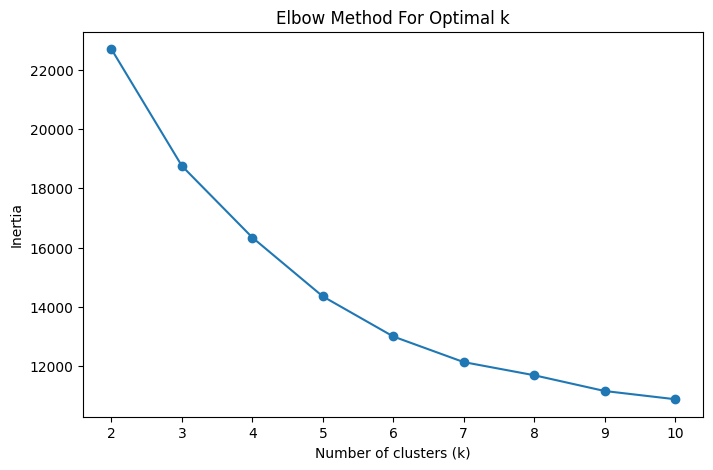

In [2]:
# Elbow method to determine optimal number of clusters
inertia = []
K_range = range(2, 11)  # Trying between 2 and 10 clusters

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plot inertia to find the elbow
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()



## K-Means Clustering

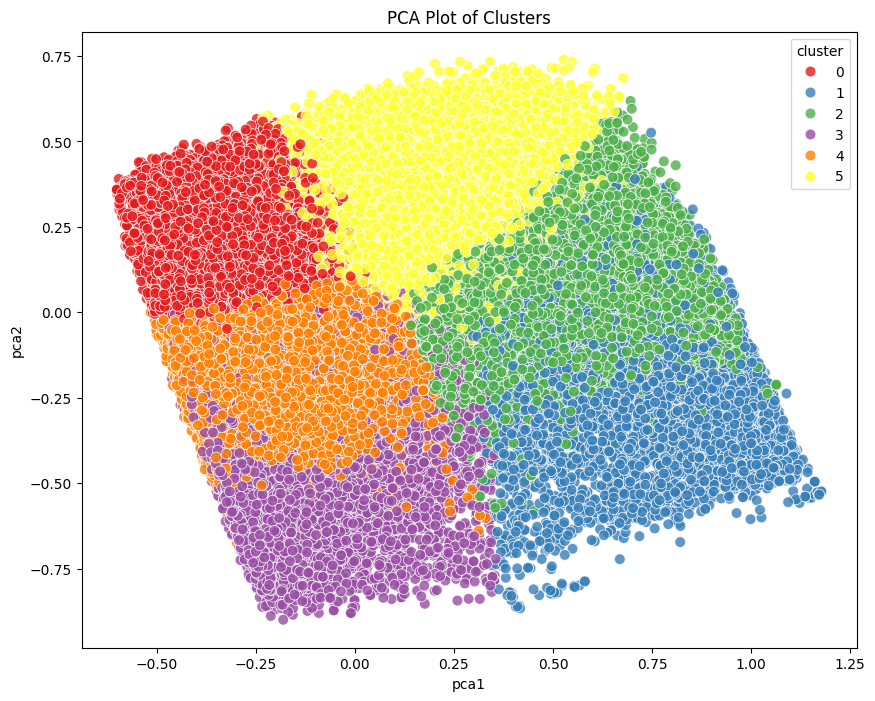

In [48]:
from sklearn.decomposition import PCA

# Apply k-means (k = 6 seems reasonable since no distinct elbow)
kmeans = KMeans(n_clusters=6, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

# Reduce the dimensionality to 2D for visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X)
df['pca1'], df['pca2'] = pca_components[:, 0], pca_components[:, 1]

# Plot the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x='pca1', y='pca2', hue='cluster', palette='Set1', s=60, alpha=0.8)
plt.title('PCA Plot of Clusters')
plt.show()



Each color represents a distinct cluster found by the k-means algorithm.
The fact that the clusters form relatively distinct shapes in the PCA plot means that k-means has been successful at separating the data points into groups based on the features. Overlaps or boundary areas (such as between clusters 3 and 4) might indicate songs that are somewhat similar in their audio features, leading to ambiguity in their clustering.

## Cluster Means

The first table provides the mean values for each feature within each cluster. These averages tell us about the general characteristics of each cluster based on the audio features:

In [49]:

# Get the mean values of features for each cluster
cluster_means = df.groupby('cluster')[clustering_features].mean()
print(cluster_means)


         danceability    energy   valence     tempo  acousticness  \
cluster                                                             
0            0.681744  0.770048  0.732346  0.513458      0.110471   
1            0.393082  0.203957  0.210542  0.433722      0.871259   
2            0.496391  0.338259  0.313847  0.466577      0.755583   
3            0.560398  0.767395  0.310542  0.524039      0.063325   
4            0.513789  0.763720  0.315333  0.526817      0.084118   
5            0.648758  0.603777  0.702348  0.491473      0.604810   

         speechiness_log  instrumentalness_log  liveness_log  
cluster                                                       
0               0.088230              0.024943      0.175469  
1               0.052756              0.609530      0.141133  
2               0.061437              0.015306      0.163197  
3               0.073727              0.566466      0.175673  
4               0.084283              0.021189      0.202916  
5     

### Cluster 0:
High danceability (0.68), energy (0.77), and valence (0.73), meaning this cluster represents high-energy, upbeat, and danceable tracks.
Low acousticness (0.11), instrumentalness_log (0.02), and speechiness_log (0.09), suggesting that these are mainly non-acoustic, non-instrumental tracks with a focus on vocals.
### Cluster 1:
Low danceability (0.39), energy (0.20), and valence (0.21), representing slower, calmer, and more somber tracks.
Very high acousticness (0.87), meaning these are mostly acoustic tracks.
High instrumentalness_log (0.61), indicating a high proportion of instrumental tracks in this cluster.
### Cluster 2:
 Moderate danceability (0.50) and energy (0.33).
 High acousticness (0.76), suggesting this cluster contains more acoustic tracks.
Low valence (0.31), which implies a more somber or melancholic mood overall.
### Cluster 3:

Moderate danceability (0.56) and high energy (0.77), indicating energetic, moderately danceable tracks.
Low valence (0.31), suggesting these songs might be intense or dark.
Low acousticness (0.06) and high instrumentalness_log (0.57), meaning this cluster might represent high-energy instrumental tracks.
### Cluster 4:

Moderate danceability (0.51) and high energy (0.76), similar to cluster 3.
Low valence (0.31) and acousticness (0.08), which could represent high-energy, non-acoustic tracks, possibly in genres like electronic music.
### Cluster 5:

High danceability (0.65), energy (0.60), and valence (0.70), making it another cluster with generally upbeat, danceable tracks.
High acousticness (0.60), which is interesting given the higher energy and valence—this might indicate energetic acoustic tracks.   


## Lets look at the top 10 genres in the clusters

In [50]:
# Function to get top N genres for each cluster
def get_top_genres_per_cluster(cluster_distribution, top_n=10):
    top_genres = {}
    for cluster in cluster_distribution.index:
        # Sort genres by count within the cluster and get the top N
        top_genres[cluster] = cluster_distribution.loc[cluster].sort_values(ascending=False).head(top_n)
    return top_genres

# Get the top 5 genres for each cluster
top_genres = get_top_genres_per_cluster(genre_cluster_distribution, top_n=10)

# Print the top 5 genres for each cluster
for cluster, genres in top_genres.items():
    print(f"Cluster {cluster} - Top Genres:\n{genres}\n")

Cluster 0 - Top Genres:
track_genre
party        620
disco        608
kids         590
dancehall    570
dance        550
ska          518
latin        518
j-idol       486
power-pop    471
afrobeat     452
Name: 0, dtype: int64

Cluster 1 - Top Genres:
track_genre
new-age      752
ambient      685
sleep        615
classical    587
study        499
guitar       427
piano        419
disney       411
iranian      383
idm          295
Name: 1, dtype: int64

Cluster 2 - Top Genres:
track_genre
romance       670
opera         629
cantopop      580
show-tunes    545
acoustic      526
tango         486
honky-tonk    464
mandopop      429
chill         331
indian        320
Name: 2, dtype: int64

Cluster 3 - Top Genres:
track_genre
minimal-techno    751
detroit-techno    693
grindcore         626
black-metal       504
chicago-house     488
trance            453
idm               449
breakbeat         449
drum-and-bass     425
club              390
Name: 3, dtype: int64

Cluster 4 - Top Genres:


### Cluster 0:
- **Genres**: Party, Disco, Kids, Dancehall, Dance, Ska, Latin, J-idol, Power-pop, Afrobeat
- **Interpretation**: This cluster seems to group high-energy, danceable, and fun genres. Genres like **party**, **disco**, **dancehall**, and **dance** indicate that this cluster is full of upbeat, rhythmic music that's likely played at social gatherings or for dancing. The presence of **kids** music suggests this cluster also contains tracks designed for younger audiences.

### Cluster 1:
- **Genres**: New-age, Ambient, Sleep, Classical, Study, Guitar, Piano, Disney, Iranian, IDM
- **Interpretation**: This cluster represents calm, relaxing, and instrumental music. Genres like **new-age**, **ambient**, **classical**, and **study** music are known for their peaceful, low-energy qualities. This aligns with the low energy and high acousticness values of the cluster. It also includes **sleep** music and **disney** tracks, which are calming and child-friendly.

### Cluster 2:
- **Genres**: Romance, Opera, Cantopop, Show-tunes, Acoustic, Tango, Honky-tonk, Mandopop, Chill, Indian
- **Interpretation**: This cluster includes a mixture of traditional, acoustic, and more theatrical music. Genres like **romance**, **opera**, and **show-tunes** suggest a focus on vocal-heavy, emotional music, often with a narrative. **Acoustic** and **tango** highlight the acoustic nature and possibly slower tempo of this cluster. **Cantopop** and **mandopop** show the presence of Asian pop genres.

### Cluster 3:
- **Genres**: Minimal-techno, Detroit-techno, Grindcore, Black-metal, Chicago-house, Trance, IDM, Breakbeat, Drum-and-bass, Club
- **Interpretation**: This cluster is filled with high-energy, electronic, and intense genres. **Techno**, **grindcore**, **black-metal**, **trance**, and **drum-and-bass** are genres known for their fast tempos, aggressive sounds, and high energy. This aligns with the high-energy and instrumental features seen in the cluster means. This group likely represents electronic dance music (EDM) and metal genres.

### Cluster 4:
- **Genres**: Heavy-metal, Hardstyle, Metalcore, Grunge, Death-metal, World-music, Dub, Happy, Black-metal, Emo
- **Interpretation**: This cluster is dominated by rock and metal genres like **heavy-metal**, **metalcore**, **grunge**, and **death-metal**. The cluster likely contains heavy, aggressive music with strong guitars and drums. **World-music** and **dub** add a bit of variety, but the primary focus seems to be on various subgenres of metal and rock.

### Cluster 5:
- **Genres**: Comedy, Pagode, Salsa, Forro, Bluegrass, Honky-tonk, Rock-n-roll, Children, Sertanejo, Tango
- **Interpretation**: This cluster includes a variety of upbeat and folk genres like **pagode**, **salsa**, **forro**, **bluegrass**, and **honky-tonk**. These genres are often acoustic or traditional, aligning with the cluster's high acousticness. **Comedy** music suggests humor or spoken-word tracks, and **rock-n-roll** and **tango** are lively genres.

### Summary of Cluster Characteristics:
- **Cluster 0**: Upbeat, party, and dance-oriented music.
- **Cluster 1**: Calm, instrumental, and relaxing music for study, sleep, or meditation.
- **Cluster 2**: Traditional and theatrical music, including opera, tango, and acoustic genres.
- **Cluster 3**: High-energy, electronic, and intense music like techno, metal, and trance.
- **Cluster 4**: Heavy metal, rock, and aggressive music genres.
- **Cluster 5**: Upbeat, traditional, and acoustic folk genres like salsa, forro, and bluegrass.

In [51]:
# Labelize the clusters

cluster_labels = {
    0: 'Upbeat Dance & Party Music',
    1: 'Calm Instrumental & Study Music',
    2: 'Traditional & Vocal-heavy Music',
    3: 'High-energy Electronic & Metal',
    4: 'Heavy Metal & Rock',
    5: 'Upbeat Folk & Acoustic Music'
}

# Create a new column in the dataframe for these labels
df['cluster_label'] = df['cluster'].map(cluster_labels)

# Check the first few rows to ensure the labels are added
df[['cluster', 'cluster_label']].head()


,cluster,cluster_label
0,0,Upbeat Dance & Party Music
1,2,Traditional & Vocal-heavy Music
2,4,Heavy Metal & Rock
3,2,Traditional & Vocal-heavy Music
4,2,Traditional & Vocal-heavy Music


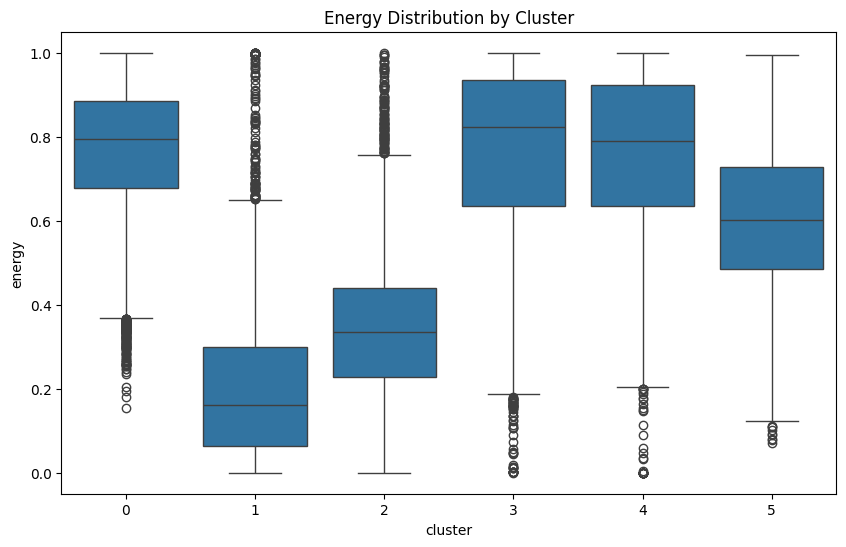

In [52]:
# Box plot of features by cluster
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='cluster', y='energy')
plt.title('Energy Distribution by Cluster')
plt.show()
